In [1]:
# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn
# import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Visualization libraries
# import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder,MinMaxScaler
# from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# import pip install tensorflow as tf
from joblib import dump, load

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from copy import deepcopy
from tqdm import tqdm

# Seed for reproducability
seed = 1024
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

2025-02-20 14:29:03.982818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 14:29:03.982856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 14:29:03.983874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 14:29:03.988861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 14:29:04.542882: W tensorflow/compiler/tf2

In [82]:
import openml
#openml.config.apikey = 'FILL_IN_OPENML_API_KEY'  # set the OpenML Api Key
# SUITE_ID = 336 # Regression on numerical features
SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

# for task_id in benchmark_suite.tasks:  # iterate over all tasks
#     task = openml.tasks.get_task(task_id)  # download the OpenML task
#     print(task_id)
    # dataset = task.get_dataset()
    # X, y, categorical_indicator, attribute_names = dataset.get_data(
    #     dataset_format="dataframe", target=dataset.default_target_attribute
    # )
# 361063 house
# 361065 MagicTelescope
# 361069 Higgs
# 361277 California Housing

In [83]:
benchmark_suite.tasks

[361055,
 361060,
 361061,
 361062,
 361063,
 361065,
 361066,
 361068,
 361069,
 361070,
 361273,
 361274,
 361275,
 361276,
 361277,
 361278]

In [84]:
task_id_selected = [361055,361060,361066,361273,361275,361068,361277] # credit,electricity,bankmarketing,Diabetes130US, default-of-credit-card-clients MiniBooNE
task_id_name = ['credit','electricity','bankmarketing','Diabetes130US', 'default-of-credit-card-clients','MiniBooNE','CaliforniaHousing']

In [85]:
def acc(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """
        Calculates the accuracy score between labels and predictions.
        
        :param y_true: The true labels of the data
        :param y_pred: The predictions for the data
        
        :return: a floating point number denoting the accuracy
    """
    return np.round(accuracy_score(y_true, y_pred) * 100, 2)

In [86]:
def produce_soft_labels(data_X, data_y, round_num, fold_num, k=1,model='rf',tree_nums=300,min_samples_leaf=5):

    soft_label = np.zeros([data_X.shape[0], len(np.unique(data_y))])

    for i in range(round_num):
        kf = KFold(n_splits=fold_num)
        for train_index, test_index in kf.split(X=data_X, y=data_y, groups=data_y):
            train_X,train_Y = data_X.iloc[train_index], data_y.iloc[train_index]
            test_X = data_X.iloc[test_index]
            # train_X,train_Y=train_set[:, :-1],train_set[:, -1].astype(int)
            # test_X=test_set[:, :-1]
            if model=='rf':
                clf = RandomForestClassifier(tree_nums, min_samples_leaf=min_samples_leaf, criterion="gini")
            clf.fit(train_X, train_Y)

            pred_prob = clf.predict_proba(test_X)
            soft_label[test_index] += pred_prob

    soft_label /= round_num

    hard_label = np.zeros([data_X.shape[0], len(np.unique(data_y))])
    for i in range(np.shape(data_X)[0]):
        hard_label[i][int(data_y.iloc[i])] = 1

    soft_label = (soft_label + hard_label*k) / (k+1)

    return soft_label

In [87]:
# dataset = pd.read_csv('../Dataset/connect4/c4_game_database.csv')
# dataset = pd.read_csv('../Dataset/connect4/connect-4.data')
# dataset = pd.read_csv('../Dataset/heart.csv')
# dataset = pd.read_csv('../Dataset/Acoustic_Extinguisher_Fire_Dataset.csv')
# dataset = datasets.load_iris()
task_id_index = 3
task_id = task_id_selected[task_id_index]
task_name = task_id_name[task_id_index]
task = openml.tasks.get_task(task_id)
dataset = task.get_dataset()
X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )

/home/wenbo/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/wenbo/anaconda3/lib/python3.11/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/home/wenbo/anaconda3/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting

In [11]:
data = datasets.load_breast_cancer()
print(data.data.shape)
X,y = data.data, data.target
task_name = 'breast cancer'
# train_x, test_x, train_y, test_y = train_test_split(data.data, data.target, test_size=0.2, random_state=8)

(569, 30)


In [9]:
from sklearn.datasets import fetch_covtype
X, y = fetch_covtype(return_X_y=True) #第一次会下载数据约90M CVS
print(X.shape) #(581012, 54)
print(y.shape)

(581012, 54)
(581012,)


In [221]:
task_name = 'cover'

In [88]:
X = pd.DataFrame(X)
y = pd.Series(y).astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71090 entries, 0 to 71089
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   time_in_hospital    71090 non-null  uint8
 1   num_lab_procedures  71090 non-null  uint8
 2   num_medications     71090 non-null  uint8
 3   number_outpatient   71090 non-null  uint8
 4   number_emergency    71090 non-null  uint8
 5   number_inpatient    71090 non-null  uint8
 6   number_diagnoses    71090 non-null  uint8
dtypes: uint8(7)
memory usage: 486.1 KB


In [89]:
X.max(0)

time_in_hospital       14
num_lab_procedures    129
num_medications        75
number_outpatient      42
number_emergency       76
number_inpatient       19
number_diagnoses       16
dtype: uint8

In [90]:
y

0        0
1        0
2        0
3        0
4        0
        ..
71085    1
71086    1
71087    1
71088    1
71089    1
Name: readmitted, Length: 71090, dtype: category
Categories (2, object): ['0' < '1']

In [ ]:
# X = dataset.drop('STATUS', axis = 1)
# y = dataset['STATUS']

# X = dataset.iloc[:,:-1]
# y = dataset.iloc[:, -1]

# X = dataset.data
# y = dataset.target

In [ ]:
# X = (X-X.min(0)-0.5*(X.max(0)-X.min(0)))/(X.max(0)-X.min(0))*2
# X = (X-X.min(0))/(X.max(0)-X.min(0))

# 
# X = X*1.0
# X = (X-X.min()-0.5*(X.max()-X.min()))/(X.max()-X.min())*2

In [ ]:
# y = y + 1

In [91]:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=0.2,random_state=seed)
# random——seed: 42,37

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=18)


# if task_id in [361055,361066,361273,361275] :
qt = QuantileTransformer(output_distribution="uniform", random_state=18)
X_train = qt.fit_transform(X_train)
X_val_test = qt.transform(X_val_test)

X_test,X_val,y_test, y_val  = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=18)

In [92]:
X_test.max(0)

array([1.        , 0.99937888, 1.        , 1.        , 1.        ,
       0.99974975, 1.        ])

In [93]:
X_test

array([[0.55355355, 0.86236236, 0.23073073, ..., 0.        , 0.76126126,
        0.75225225],
       [0.22772773, 0.38288288, 0.23073073, ..., 0.99449449, 0.        ,
        0.75225225],
       [0.        , 0.3023023 , 0.34484484, ..., 0.        , 0.        ,
        0.06406406],
       ...,
       [0.75775776, 0.47247247, 0.57307307, ..., 0.        , 0.76126126,
        0.75225225],
       [0.87187187, 0.92642643, 0.57307307, ..., 0.        , 0.        ,
        0.75225225],
       [0.67317317, 0.95545546, 0.67167167, ..., 0.        , 0.        ,
        0.75225225]])

In [ ]:
# st_sc = StandardScaler()
# scaler = st_sc.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

(array([[2.0000e+03, 0.0000e+00, 2.4700e+03, 2.5550e+03, 0.0000e+00,
         1.9020e+03, 1.3560e+03, 1.0780e+03, 1.4120e+03, 1.5160e+03],
        [1.4960e+03, 1.3720e+03, 1.3110e+03, 1.4060e+03, 1.6620e+03,
         1.2340e+03, 1.3540e+03, 1.4640e+03, 1.5370e+03, 1.4530e+03],
        [1.5420e+03, 1.2750e+03, 1.5640e+03, 8.8400e+02, 1.6410e+03,
         1.5950e+03, 1.3780e+03, 1.5400e+03, 1.3170e+03, 1.5530e+03],
        [1.1908e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2020e+03, 1.1790e+03],
        [1.2725e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5640e+03],
        [9.4760e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.7910e+03, 1.0770e+03, 9.4500e+02],
        [1.3320e+03, 1.5330e+03, 1.4740e+03, 1.4470e+03, 1.4830e+03,
         0.0000e+00, 0.0000e+00, 7.0080e+03, 0.0000e+00, 1.2000e+01]]),
 array([0. , 0.1, 0.2, 0.

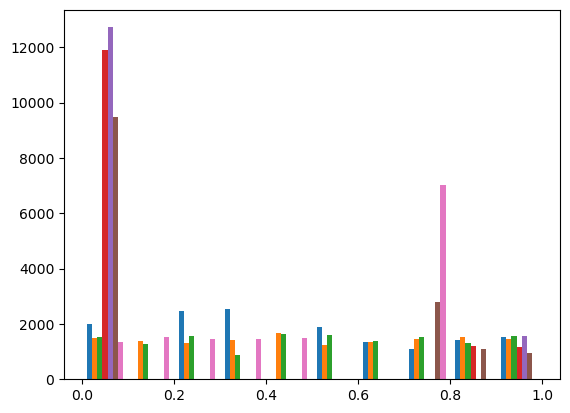

In [94]:
plt.hist(X_test)

In [ ]:
# data_train = np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]).astype('float32'), y_train.reshape(len(y_train),1).astype('float32')),1)
# soft_label = produce_soft_labels(X_train,y_train, round_num=1, fold_num=2, k=1, model='rf')

In [ ]:
# [X_train_resize.append(cv2.resize(X_train[i], [7,7])) for i in range(X_train.shape[0])]
# X_train_resize = np.array([cv2.resize(X_train[i], [7,7],cv2.INTER_AREA) for i in range(X_train.shape[0])])
# X_test_resize = np.array([cv2.resize(X_test[i], [7,7],cv2.INTER_AREA) for i in range(X_test.shape[0])])
# plt.subplot(221)
# plt.imshow(X_train_resize[0], cmap=plt.get_cmap('gray'))
# plt.subplot(222)
# plt.imshow(X_train_resize[1], cmap=plt.get_cmap('gray'))
# plt.subplot(223)
# plt.imshow(X_train_resize[2], cmap=plt.get_cmap('gray'))
# plt.subplot(224)
# plt.imshow(X_train_resize[3], cmap=plt.get_cmap('gray'))
# # show the plot
# plt.show()

In [ ]:
# X_train_resize, X_test_resize = X_train,X_test

# num_pixels = X_train_resize.shape[1] * X_train_resize.shape[2]

# X_train_resize = X_train_resize.reshape(X_train_resize.shape[0], num_pixels).astype('float32')
# X_test_resize = X_test_resize.reshape(X_test_resize.shape[0], num_pixels).astype('float32')


# print('X_train.shape after resize and reshape: ' , X_train_resize.shape)

# # normalize inputs from 0-255 to 0-1
# X_train_resize = X_train_resize / 255
# X_test_resize = X_test_resize / 255

# one hot encode outputs
# y_train = np_utils.to_categorical(y_train)
# Y_train = np_utils.to_categorical(y_train)
# Y_test = np_utils.to_categorical(y_test)

# num_classes = Y_test.shape[1]

In [99]:
# Train baseline decision tree model

best_depth = 6
# Train baseline decision tree model
clf_rf = RandomForestClassifier(250, min_samples_leaf=3, criterion="gini",random_state=seed,max_depth=best_depth)
clf_rf.fit(X_train, y_train)


clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=1024)

In [100]:
clf.tree_.max_depth

6

In [101]:
clf_rf.estimators_[0].tree_.max_depth

6

In [102]:

rf_preds_baseline = clf_rf.predict(X_test)
train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_test)
acc_baseline_train = acc(train_preds_baseline, y_train)
acc_baseline_val = acc(val_preds_baseline, y_test)
acc_baseline_rf = acc(rf_preds_baseline, y_test)
print(f'Training accuracy for our baseline (using all pixel features): {acc_baseline_train}%')
print(f'Validation accuracy for our baseline (using all pixel features): {acc_baseline_val}%')
print(f'Validation accuracy for our teacher rf model (using all pixel features): {acc_baseline_rf}%')

Training accuracy for our baseline (using all pixel features): 60.95%
Validation accuracy for our baseline (using all pixel features): 60.91%
Validation accuracy for our teacher rf model (using all pixel features): 61.17%


In [103]:
clf.tree_.feature

array([ 5,  6,  3,  4,  0,  1, -2, -2,  2, -2, -2,  2,  1, -2, -2,  2, -2,
       -2,  1,  0,  2, -2, -2,  2, -2, -2,  0,  2, -2, -2,  3, -2, -2,  3,
        4,  2,  2, -2, -2,  2, -2, -2,  2,  2, -2, -2,  0, -2, -2,  1,  0,
        2, -2, -2,  1, -2, -2,  4,  3, -2, -2,  4, -2, -2,  5,  3,  6,  1,
        2, -2, -2,  4, -2, -2,  2,  4, -2, -2,  1, -2, -2,  4,  2,  0, -2,
       -2,  1, -2, -2,  1,  2, -2, -2,  1, -2, -2,  3,  5,  4,  2, -2, -2,
        2, -2, -2,  5,  2, -2, -2,  4, -2, -2,  4,  2,  6, -2, -2,  1, -2,
       -2,  0,  3, -2, -2,  5, -2, -2], dtype=int64)

In [50]:
test_rep = export_text(clf)
print(test_rep)

|--- feature_23 <= 0.67
|   |--- feature_27 <= 0.73
|   |   |--- feature_22 <= 0.60
|   |   |   |--- feature_13 <= 0.77
|   |   |   |   |--- class: 1
|   |   |   |--- feature_13 >  0.77
|   |   |   |   |--- class: 1
|   |   |--- feature_22 >  0.60
|   |   |   |--- feature_24 <= 0.58
|   |   |   |   |--- class: 1
|   |   |   |--- feature_24 >  0.58
|   |   |   |   |--- class: 0
|   |--- feature_27 >  0.73
|   |   |--- feature_21 <= 0.42
|   |   |   |--- class: 1
|   |   |--- feature_21 >  0.42
|   |   |   |--- class: 0
|--- feature_23 >  0.67
|   |--- feature_26 <= 0.48
|   |   |--- feature_7 <= 0.40
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.40
|   |   |   |--- class: 1
|   |--- feature_26 >  0.48
|   |   |--- feature_11 <= 0.01
|   |   |   |--- class: 1
|   |   |--- feature_11 >  0.01
|   |   |   |--- class: 0



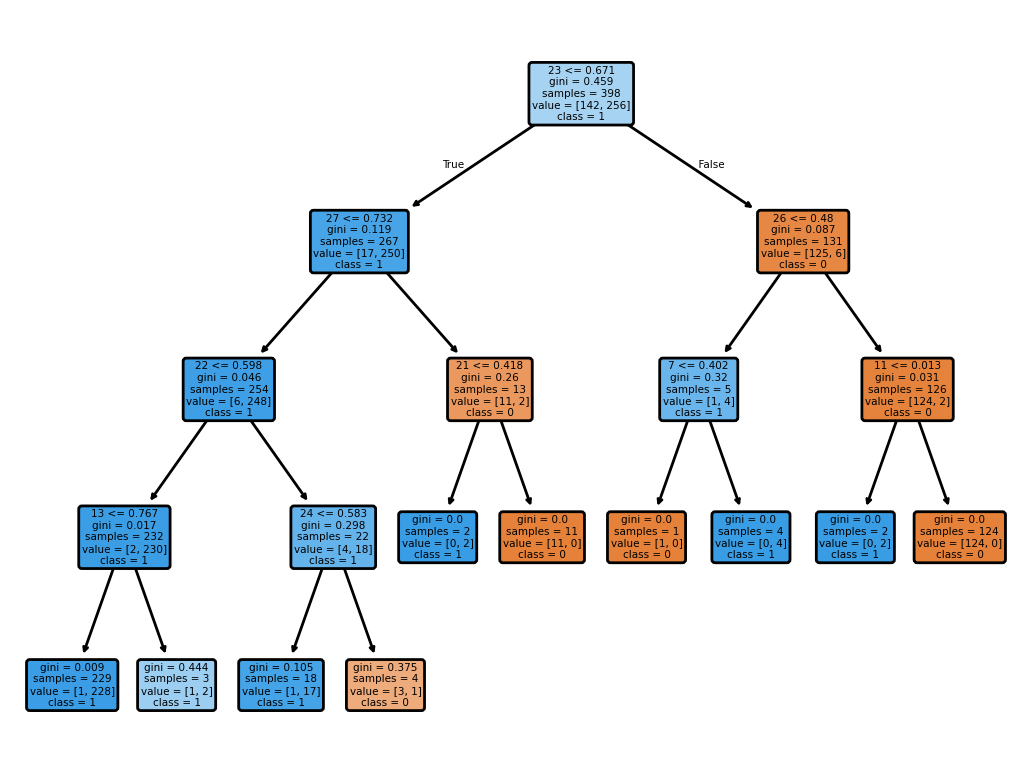

In [51]:
fig = plt.figure(dpi=200)
_ = plot_tree(clf,feature_names=X.columns.values.tolist(),class_names=['0', '1','2'],rounded=True,filled=True)

# plt.savefig('tree_plot.png',transparent=True)

In [ ]:
#soft_label = produce_soft_labels(X_train,y_train, round_num=1, fold_num=2, k=1, model='rf',tree_nums=300,min_samples_leaf=3)
# soft_label = np.array(soft_label).reshape(-1,1)

In [ ]:
#soft_label

In [104]:
def tree_path(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    # threshold = clf.tree_.threshold
    max_depth = clf.tree_.max_depth

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)



    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    node_path = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)
    left_right = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)

    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    depth = 0
    for i in range(n_nodes):
        previous_depth = depth
        depth = node_depth[i]
        
        if i!=0:
            node_path[i, :depth] = node_path[i-1, :depth]
            left_right[i, :depth] = left_right[i-1, :depth]
        node_path[i, depth] = i
        if depth>previous_depth:
            left_right[i, depth] = 0
        else:
            left_right[i, depth] = 1

        
    node_path_left_right = np.concatenate((node_path[:,:-1,np.newaxis],left_right[:,1:,np.newaxis]),axis = 2) 
    node_path_left_right = node_path_left_right[feature==-2]
    node_path = node_path_left_right[:,:,0]
    return node_depth, node_path_left_right

In [105]:
node_depth_forest = []
node_path_forest = []
forest_index = []
forest_threshold = []
forest_leaf_value = []
node_accu = 0
for i in range(250):
    node_depth_temp,node_path_temp = tree_path(clf_rf.estimators_[i])
    node_path_temp[:,:,0] = node_path_temp[:,:,0] + node_accu
    node_depth_forest.extend(node_depth_temp)
    node_path_forest.extend(node_path_temp)
    # node_path_forest = np.concatenate((node_path_forest,node_path_temp),0) 
    forest_index.extend(clf_rf.estimators_[i].tree_.feature)
    forest_threshold.extend(clf_rf.estimators_[i].tree_.threshold)
    forest_leaf_value.extend(clf_rf.estimators_[i].tree_.value)
    node_accu = node_accu + len(node_depth_temp)

In [106]:
leaf_index = np.array(forest_index)==-2
forest_node_path = np.array(node_path_forest)[:,:,0]
forest_leaf_depth = np.array(node_depth_forest)[leaf_index]


In [107]:
class SDT(nn.Module):

    def __init__(self, clf,node_depth,node_path_left_right, args):
        super(SDT, self).__init__()
        self.args = args
        self.clf = clf
        self.device = torch.device("cuda" if self.args['use_cuda'] else "cpu")
        self.leaf_num = clf.tree_.n_leaves
        self.leaf_index = clf.tree_.feature==-2
        self.node_depth = node_depth
        self.leaf_depth = node_depth[self.leaf_index]
        self.node_path = node_path_left_right[:,:,0]
        self.node_path_left_right = node_path_left_right

        self.node_gain = nn.Parameter(data=torch.ones(node_path_left_right[:,:,0].shape)*(-10),requires_grad=False)
        self.node_threshold = nn.Parameter(torch.tensor(clf.tree_.threshold[self.node_path],dtype=torch.float),requires_grad=True)
        self.register_parameter('node_gain',self.node_gain)
        self.register_parameter('node_threshold',self.node_threshold)

        self.leaf_nodes = nn.Parameter(data = torch.tensor(clf.tree_.value[self.leaf_index,0,:]), requires_grad = True)
        self.register_parameter('leaf_node',self.leaf_nodes)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, X, is_training_data=False):

        _mu = self._forward(X)

        if is_training_data:
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(output,dim=1)
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)  
            return torch.log(output+1e-18)
        else:
            # output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device),dim=1))  
            output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)
            # print(output.shape)
            return torch.log(output+1e-18)


    def _forward(self, X):
        """Implementation on the data forwarding process."""
        
        batch_size = X.size()[0]
        X = X[:,self.clf.tree_.feature[self.node_path]]
        gain = self.node_gain.to(self.device)
        # print(X.shape)
        # print(self.node_threshold.shape)
        X = (X  - self.node_threshold.to(self.device)) * gain
        X = self.dropout(X)
        path_prob = torch.sigmoid(X)
        path_prob = torch.unsqueeze(path_prob, dim=3)
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=3)
        _mu = X.data.new(batch_size, self.leaf_num).fill_(1.0)

        for layer_idx in range(1, self.args['depth']+1):
            select_leaf = self.leaf_depth==layer_idx
            if sum(select_leaf) > 0:
                mu_temp = path_prob[:,select_leaf,:layer_idx,:]
                mu_temp_index = torch.argwhere(mu_temp[0,:,:,0])
                mu_temp = mu_temp[:,mu_temp_index[:,0].reshape(mu_temp[0,:,:,0].shape),mu_temp_index[:,1].reshape(mu_temp[0,:,:,0].shape),node_path_left_right[select_leaf,:layer_idx,1]]
                _mu[:,select_leaf] = torch.prod(mu_temp,-1)


        return _mu

    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda))

In [108]:
class SRF(nn.Module):

    def __init__(self, forest, args):
        super(SRF, self).__init__()
        self.args = args
        self.forest = forest
        self.device = torch.device("cuda:0" if self.args['use_cuda'] else "cpu")
        

        node_depth_forest = []
        node_path_forest = []
        forest_index = []
        forest_threshold = []
        forest_leaf_value = []
        node_accu = 0
        for i in range(250):
            node_depth_temp,node_path_temp = tree_path(self.forest.estimators_[i])
            node_path_temp[:,:,0] = node_path_temp[:,:,0] + node_accu
            node_depth_forest.extend(node_depth_temp)
            node_path_forest.extend(node_path_temp) 
            forest_index.extend(self.forest.estimators_[i].tree_.feature)
            forest_threshold.extend(self.forest.estimators_[i].tree_.threshold)
            forest_leaf_value.extend(self.forest.estimators_[i].tree_.value)
            node_accu = node_accu + len(node_depth_temp)
        self.feature_index = np.array(forest_index)
        self.leaf_index = self.feature_index==-2
        forest_node_path = np.array(node_path_forest)[:,:,0]
        forest_leaf_depth = np.array(node_depth_forest)[self.leaf_index]

        
        

        self.node_depth = np.array(node_depth_forest)
        self.leaf_depth = forest_leaf_depth
        self.node_path = forest_node_path
        self.node_path_left_right = np.array(node_path_forest)
        self.leaf_num = self.node_path_left_right.shape[0]



        self.node_gain = nn.Parameter(data=torch.ones(forest_node_path.shape)*(-10),requires_grad=False)

        self.node_threshold = nn.Parameter(torch.tensor(np.array(forest_threshold)[forest_node_path],dtype=torch.float),requires_grad=True)

        

        self.register_parameter('node_gain',self.node_gain)
        self.register_parameter('node_threshold',self.node_threshold)

        self.leaf_nodes = nn.Parameter(data = torch.tensor(np.array(forest_leaf_value)[self.leaf_index,0,:]), requires_grad = True)
        self.register_parameter('leaf_node',self.leaf_nodes)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, X, is_training_data=False):

        _mu = self._forward(X)

        if is_training_data:
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(output,dim=1)
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)  
            return torch.log(output+1e-18)
        else:
            # output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device),dim=1))  
            output = torch.matmul(_mu.to(self.device,torch.float), torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)
            # print(output.shape)
            return torch.log(output+1e-18)


    def _forward(self, X):
        """Implementation on the data forwarding process."""
        
        batch_size = X.size()[0]
        # X = X[:,self.clf.tree_.feature[self.node_path]]
        X = X[:,self.feature_index[self.node_path] ]
        gain = self.node_gain.to(self.device)
        # print(X.shape)
        # print(self.node_threshold.shape)
        X = (X  - self.node_threshold.to(self.device)) * gain
        X = self.dropout(X)
        path_prob = torch.sigmoid(X)
        path_prob = torch.unsqueeze(path_prob, dim=3)
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=3)
        _mu = X.data.new(batch_size, self.leaf_num).fill_(1.0)

        for layer_idx in range(1, self.args['depth']+1):
            select_leaf = self.leaf_depth==layer_idx
            if sum(select_leaf) > 0:
                mu_temp = path_prob[:,select_leaf,:layer_idx,:]
                mu_temp_index = torch.argwhere(mu_temp[0,:,:,0])
                mu_temp = mu_temp[:,mu_temp_index[:,0].reshape(mu_temp[0,:,:,0].shape),mu_temp_index[:,1].reshape(mu_temp[0,:,:,0].shape),self.node_path_left_right[select_leaf,:layer_idx,1]]
                _mu[:,select_leaf] = torch.prod(mu_temp,-1)


        return _mu

    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda))

In [109]:

class make_dataset(Dataset):
    def __init__(self, X, y):
        self.X_data = X
        self.y_data = y

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        Y = self.y_data[idx,:]
        X = self.X_data[idx,:]
        return X, Y
# Y_train = to_categorical(y_train)
# Y_test = to_categorical(y_test)
# X_train = np.array(X_train)
# X_test = np.array(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
X_train = torch.tensor(np.array(X_train),dtype=torch.float32)
X_test = torch.tensor(np.array(X_test),dtype=torch.float32)
X_val = torch.tensor(np.array(X_val),dtype=torch.float32)
# y_train = torch.tensor(y_train)
# y_test  = torch.tensor(y_test)
# soft_label = y_train






In [110]:
y_test.shape

(14289, 2)

In [111]:
np.unique(y_test)

array([0., 1.], dtype=float32)

In [120]:
# Parameters
args = {}
# args['input_dim'] = 7 * 7    # the number of input dimensions
args['output_dim'] = y_test.shape[1]        # the number of outputs (i.e., # classes on MNIST)
args['input_dim'] = X.shape[1]    # the number of input dimensions
args['depth'] = best_depth            # tree depth
args['lamda'] = 1e-5           # coefficient of the regularization term
args['lr'] = 1e-3              # learning rate 1e-3
args['weight_decaly'] = 5e-5     # weight decay 5e-5
args['batch_size'] = 2000       # batch size 20 [0] 
args['epochs'] = 100           # the number of training epochs
args['log_interval'] = 100     # the number of batches to wait before printing logs
args['use_cuda'] = True       # whether to use GPU
node_depth,node_path_left_right = tree_path(clf)
tree = SDT(clf,node_depth,node_path_left_right,args)
forest = SRF(clf_rf,args)

# optimizer = torch.optim.SGD(tree.parameters(), lr=args['lr'], momentum=0.9)
optimizer_tree = torch.optim.Adam(tree.parameters(), lr=args['lr'],weight_decay=args['weight_decaly'])
optimizer_forest = torch.optim.Adam(forest.parameters(), lr=args['lr'],weight_decay=args['weight_decaly'])
criterion_tree = nn.CrossEntropyLoss()
criterion_forest = nn.CrossEntropyLoss()
device = torch.device("cuda" if args['use_cuda'] else "cpu")
tree = tree.to(device)
forest = forest.to(device)
best_val_acc_tree = 00.0
best_val_acc_forest = 00.0

testing_acc_list_tree = []
testing_acc_list_forest = []
training_loss_list = []

In [121]:
train_loader = torch.utils.data.DataLoader(
        # make_dataset(X = X_train,y = soft_label),
        make_dataset(X = X_train,y = y_train),
        batch_size=args['batch_size'],
        shuffle=True,
    )
val_loader = torch.utils.data.DataLoader(
        make_dataset(X= X_val, y=y_val),
        batch_size=50,
        shuffle=False,
    )
test_loader = torch.utils.data.DataLoader(
        make_dataset(X= X_test, y=y_test),
        batch_size=50,
        shuffle=False,
    )

In [118]:
task_name

'Diabetes130US'

In [115]:
acc_baseline_val

60.91

In [122]:

dump(clf_rf, './model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_rf)+'_rf.joblib')
dump(clf, './model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_val)+'_dt.joblib') 

for epoch in tqdm(range(args['epochs'])):
    
    # Training
    tree.train()
    forest.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_tree.zero_grad()
        optimizer_forest.zero_grad()
        
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        
        
        # target_onehot = onehot_coding(target, device, args['output_dim'])
        # print(data.shape)
        output1 = tree.forward(data, is_training_data=True)
        output2 = forest.forward(data, is_training_data=True)
        # target = torch.argmax(target,1)
        # loss = criterion(output, target.view(-1))
        loss1 = criterion_tree(output1, target)
        loss2 = criterion_forest(output2, target)
        # loss += penalty

        
        # torch.autograd.set_detect_anomaly(True)
        loss1.backward()
        loss2.backward()
        optimizer_tree.step()
        optimizer_forest.step()

        # Print training status
        if batch_idx % args['log_interval'] == 0:
            pred1 = torch.argmax(output1,1)
            pred2 = torch.argmax(output2,1)
            correct_tree = pred1.eq(torch.argmax(target,1)).sum()
            correct_forest = pred2.eq(torch.argmax(target,1)).sum()
            # correct = pred.eq(target.view(-1).data).sum()

            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                " Correct: {:03d}/{:03d}"
            )
            print(msg.format(epoch, batch_idx, loss1, correct_tree, batch_size))
            print(msg.format(epoch, batch_idx, loss2, correct_forest, batch_size))
            training_loss_list.append([loss1.cpu().data.numpy(),loss2.cpu().data.numpy()])

    # Evaluating
    tree.eval()
    forest.eval()
    correct_tree = 0.
    correct_forest = 0.
    with torch.no_grad():
        torch.cuda.empty_cache()
        for batch_idx, (data, target) in enumerate(val_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)
            

            # output = torch.softmax(tree.forward(data),dim=1)
            output1 = tree.forward(data)
            output2 = forest.forward(data)
            pred1 = torch.argmax(output1,1)
            pred2 = torch.argmax(output2,1)
            correct_tree += pred1.eq(torch.argmax(target,1)).sum()
            correct_forest += pred2.eq(torch.argmax(target,1)).sum()

        accuracy_tree = 100.0 * float(correct_tree) / len(val_loader.dataset)
        accuracy_forest = 100.0 * float(correct_forest) / len(val_loader.dataset)
        msg = (
                "\nEpoch: {:02d} | Validation Accuracy: {}/{} ({:.3f}%) |"
                " Historical Best: {:.3f}%\n"
            )
        print(
                msg.format(
                    epoch, correct_tree,
                    len(val_loader.dataset),
                    accuracy_tree,
                    best_val_acc_tree
                )
            )
        print(
                msg.format(
                    epoch, correct_forest,
                    len(val_loader.dataset),
                    accuracy_forest,
                    best_val_acc_forest
                )
            )
        
        if accuracy_tree >= best_val_acc_tree:
            best_val_acc_tree = accuracy_tree
            
            correct = 0.

            with torch.no_grad():
                torch.cuda.empty_cache()
                for batch_idx, (data, target) in enumerate(test_loader):

                    batch_size = data.size()[0]
                    data, target = data.to(device), target.to(device)
                    # tree = tree.to(device)

                    # output = torch.softmax(tree.forward(data),dim=1)
                    output = tree.forward(data)
                    pred = torch.argmax(output,1)
                    correct += pred.eq(torch.argmax(target,1)).sum()

                accuracy_test = 100.0 * float(correct) / len(test_loader.dataset)
            # if accuracy_test>=acc_baseline_val+0.1:
            if accuracy_test>=0.61:
                save_path = './model_tabular/'+task_name+'_'+str(best_depth)+'_sdt_at_epoch_'+str(epoch)+'_acc_'+str(np.round(accuracy_test,2))+'.pth'

                
                torch.save(tree.state_dict(), save_path)
            

            msg = (
                "\nEpoch: {:02d} | Testing Accuracy: {}/{} ({:.3f}%) |"
                " Best vali acc of tree model: {:.3f}%\n"
            )
            print(
                msg.format(
                    epoch, correct,
                    len(test_loader.dataset),
                    accuracy_test,
                    best_val_acc_tree
                )
            )
            testing_acc_list_tree.append(accuracy_test)

        if accuracy_forest >= best_val_acc_forest:
            best_val_acc_forest = accuracy_forest
            
            correct = 0.

            with torch.no_grad():
                torch.cuda.empty_cache()
                for batch_idx, (data, target) in enumerate(test_loader):

                    batch_size = data.size()[0]
                    data, target = data.to(device), target.to(device)
                    # tree = tree.to(device)

                    # output = torch.softmax(tree.forward(data),dim=1)
                    output = forest.forward(data)
                    pred = torch.argmax(output,1)
                    correct += pred.eq(torch.argmax(target,1)).sum()

                accuracy_test = 100.0 * float(correct) / len(test_loader.dataset)
            # if accuracy_test>=acc_baseline_rf+0.3:
            if accuracy_test>=0.61:
                save_path = './model_tabular/'+task_name+'_'+str(best_depth)+'_srf_at_epoch_'+str(epoch)+'_acc_'+str(np.round(accuracy_test,2))+'.pth'

                 
                torch.save(forest.state_dict(), save_path)
            

            msg = (
                "\nEpoch: {:02d} | Testing Accuracy: {}/{} ({:.3f}%) |"
                " Best vali acc of forest model: {:.3f}%\n"
            )
            print(
                msg.format(
                    epoch, correct,
                    len(test_loader.dataset),
                    accuracy_test,
                    best_val_acc_forest
                )
            )
            testing_acc_list_forest.append(accuracy_test)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 00 | Batch: 000 | Loss: 0.67262 | Correct: 1219/2000
Epoch: 00 | Batch: 000 | Loss: 0.67457 | Correct: 1248/2000

Epoch: 00 | Validation Accuracy: 4213.0/7038 (59.861%) | Historical Best: 0.000%


Epoch: 00 | Validation Accuracy: 4253.0/7038 (60.429%) | Historical Best: 0.000%


Epoch: 00 | Testing Accuracy: 8714.0/14289 (60.984%) | Best vali acc of tree model: 59.861%



  1%|          | 1/100 [00:07<12:35,  7.63s/it]


Epoch: 00 | Testing Accuracy: 8729.0/14289 (61.089%) | Best vali acc of forest model: 60.429%

Epoch: 01 | Batch: 000 | Loss: 0.67402 | Correct: 1172/2000
Epoch: 01 | Batch: 000 | Loss: 0.67677 | Correct: 1181/2000

Epoch: 01 | Validation Accuracy: 4223.0/7038 (60.003%) | Historical Best: 59.861%


Epoch: 01 | Validation Accuracy: 4256.0/7038 (60.472%) | Historical Best: 60.429%


Epoch: 01 | Testing Accuracy: 8723.0/14289 (61.047%) | Best vali acc of tree model: 60.003%



  2%|▏         | 2/100 [00:15<12:43,  7.79s/it]


Epoch: 01 | Testing Accuracy: 8729.0/14289 (61.089%) | Best vali acc of forest model: 60.472%

Epoch: 02 | Batch: 000 | Loss: 0.67019 | Correct: 1188/2000
Epoch: 02 | Batch: 000 | Loss: 0.67637 | Correct: 1201/2000


  3%|▎         | 3/100 [00:20<10:49,  6.70s/it]


Epoch: 02 | Validation Accuracy: 4222.0/7038 (59.989%) | Historical Best: 60.003%


Epoch: 02 | Validation Accuracy: 4255.0/7038 (60.458%) | Historical Best: 60.472%

Epoch: 03 | Batch: 000 | Loss: 0.66345 | Correct: 1232/2000
Epoch: 03 | Batch: 000 | Loss: 0.67205 | Correct: 1236/2000

Epoch: 03 | Validation Accuracy: 4228.0/7038 (60.074%) | Historical Best: 60.003%


Epoch: 03 | Validation Accuracy: 4253.0/7038 (60.429%) | Historical Best: 60.472%



  4%|▍         | 4/100 [00:26<10:00,  6.26s/it]


Epoch: 03 | Testing Accuracy: 8725.0/14289 (61.061%) | Best vali acc of tree model: 60.074%

Epoch: 04 | Batch: 000 | Loss: 0.66966 | Correct: 1190/2000
Epoch: 04 | Batch: 000 | Loss: 0.67618 | Correct: 1194/2000

Epoch: 04 | Validation Accuracy: 4235.0/7038 (60.173%) | Historical Best: 60.074%


Epoch: 04 | Validation Accuracy: 4252.0/7038 (60.415%) | Historical Best: 60.472%



  5%|▌         | 5/100 [00:32<09:38,  6.09s/it]


Epoch: 04 | Testing Accuracy: 8728.0/14289 (61.082%) | Best vali acc of tree model: 60.173%

Epoch: 05 | Batch: 000 | Loss: 0.67659 | Correct: 1164/2000
Epoch: 05 | Batch: 000 | Loss: 0.67914 | Correct: 1164/2000


  6%|▌         | 6/100 [00:37<09:08,  5.83s/it]


Epoch: 05 | Validation Accuracy: 4233.0/7038 (60.145%) | Historical Best: 60.173%


Epoch: 05 | Validation Accuracy: 4248.0/7038 (60.358%) | Historical Best: 60.472%

Epoch: 06 | Batch: 000 | Loss: 0.66249 | Correct: 1205/2000
Epoch: 06 | Batch: 000 | Loss: 0.67210 | Correct: 1223/2000


  7%|▋         | 7/100 [00:43<08:52,  5.73s/it]


Epoch: 06 | Validation Accuracy: 4229.0/7038 (60.088%) | Historical Best: 60.173%


Epoch: 06 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 07 | Batch: 000 | Loss: 0.66523 | Correct: 1205/2000
Epoch: 07 | Batch: 000 | Loss: 0.67622 | Correct: 1191/2000


  8%|▊         | 8/100 [00:48<08:35,  5.61s/it]


Epoch: 07 | Validation Accuracy: 4225.0/7038 (60.031%) | Historical Best: 60.173%


Epoch: 07 | Validation Accuracy: 4243.0/7038 (60.287%) | Historical Best: 60.472%

Epoch: 08 | Batch: 000 | Loss: 0.65842 | Correct: 1225/2000
Epoch: 08 | Batch: 000 | Loss: 0.67162 | Correct: 1253/2000


  9%|▉         | 9/100 [00:53<08:22,  5.53s/it]


Epoch: 08 | Validation Accuracy: 4232.0/7038 (60.131%) | Historical Best: 60.173%


Epoch: 08 | Validation Accuracy: 4243.0/7038 (60.287%) | Historical Best: 60.472%

Epoch: 09 | Batch: 000 | Loss: 0.66571 | Correct: 1198/2000
Epoch: 09 | Batch: 000 | Loss: 0.67390 | Correct: 1203/2000


 10%|█         | 10/100 [00:59<08:17,  5.53s/it]


Epoch: 09 | Validation Accuracy: 4232.0/7038 (60.131%) | Historical Best: 60.173%


Epoch: 09 | Validation Accuracy: 4245.0/7038 (60.315%) | Historical Best: 60.472%

Epoch: 10 | Batch: 000 | Loss: 0.65970 | Correct: 1229/2000
Epoch: 10 | Batch: 000 | Loss: 0.67355 | Correct: 1215/2000

Epoch: 10 | Validation Accuracy: 4240.0/7038 (60.244%) | Historical Best: 60.173%


Epoch: 10 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%



 11%|█         | 11/100 [01:04<08:14,  5.55s/it]


Epoch: 10 | Testing Accuracy: 8716.0/14289 (60.998%) | Best vali acc of tree model: 60.244%

Epoch: 11 | Batch: 000 | Loss: 0.66048 | Correct: 1222/2000
Epoch: 11 | Batch: 000 | Loss: 0.67347 | Correct: 1219/2000

Epoch: 11 | Validation Accuracy: 4244.0/7038 (60.301%) | Historical Best: 60.244%


Epoch: 11 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%



 12%|█▏        | 12/100 [01:10<08:09,  5.56s/it]


Epoch: 11 | Testing Accuracy: 8715.0/14289 (60.991%) | Best vali acc of tree model: 60.301%

Epoch: 12 | Batch: 000 | Loss: 0.66447 | Correct: 1179/2000
Epoch: 12 | Batch: 000 | Loss: 0.67431 | Correct: 1207/2000


 13%|█▎        | 13/100 [01:16<08:03,  5.56s/it]


Epoch: 12 | Validation Accuracy: 4239.0/7038 (60.230%) | Historical Best: 60.301%


Epoch: 12 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 13 | Batch: 000 | Loss: 0.67102 | Correct: 1157/2000
Epoch: 13 | Batch: 000 | Loss: 0.67771 | Correct: 1176/2000


 14%|█▍        | 14/100 [01:21<07:53,  5.51s/it]


Epoch: 13 | Validation Accuracy: 4238.0/7038 (60.216%) | Historical Best: 60.301%


Epoch: 13 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%

Epoch: 14 | Batch: 000 | Loss: 0.66682 | Correct: 1176/2000
Epoch: 14 | Batch: 000 | Loss: 0.67755 | Correct: 1184/2000

Epoch: 14 | Validation Accuracy: 4244.0/7038 (60.301%) | Historical Best: 60.301%


Epoch: 14 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%



 15%|█▌        | 15/100 [01:27<07:51,  5.54s/it]


Epoch: 14 | Testing Accuracy: 8721.0/14289 (61.033%) | Best vali acc of tree model: 60.301%

Epoch: 15 | Batch: 000 | Loss: 0.66354 | Correct: 1197/2000
Epoch: 15 | Batch: 000 | Loss: 0.67419 | Correct: 1216/2000

Epoch: 15 | Validation Accuracy: 4248.0/7038 (60.358%) | Historical Best: 60.301%


Epoch: 15 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%



 16%|█▌        | 16/100 [01:33<07:54,  5.65s/it]


Epoch: 15 | Testing Accuracy: 8726.0/14289 (61.068%) | Best vali acc of tree model: 60.358%

Epoch: 16 | Batch: 000 | Loss: 0.65838 | Correct: 1217/2000
Epoch: 16 | Batch: 000 | Loss: 0.67119 | Correct: 1247/2000

Epoch: 16 | Validation Accuracy: 4249.0/7038 (60.372%) | Historical Best: 60.358%


Epoch: 16 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%



 17%|█▋        | 17/100 [01:38<07:48,  5.64s/it]


Epoch: 16 | Testing Accuracy: 8710.0/14289 (60.956%) | Best vali acc of tree model: 60.372%

Epoch: 17 | Batch: 000 | Loss: 0.65991 | Correct: 1222/2000
Epoch: 17 | Batch: 000 | Loss: 0.67432 | Correct: 1209/2000


 18%|█▊        | 18/100 [01:44<07:35,  5.56s/it]


Epoch: 17 | Validation Accuracy: 4243.0/7038 (60.287%) | Historical Best: 60.372%


Epoch: 17 | Validation Accuracy: 4248.0/7038 (60.358%) | Historical Best: 60.472%

Epoch: 18 | Batch: 000 | Loss: 0.67035 | Correct: 1171/2000
Epoch: 18 | Batch: 000 | Loss: 0.67909 | Correct: 1167/2000


 19%|█▉        | 19/100 [01:49<07:29,  5.55s/it]


Epoch: 18 | Validation Accuracy: 4241.0/7038 (60.259%) | Historical Best: 60.372%


Epoch: 18 | Validation Accuracy: 4248.0/7038 (60.358%) | Historical Best: 60.472%

Epoch: 19 | Batch: 000 | Loss: 0.66126 | Correct: 1207/2000
Epoch: 19 | Batch: 000 | Loss: 0.67478 | Correct: 1199/2000


 20%|██        | 20/100 [01:54<07:19,  5.50s/it]


Epoch: 19 | Validation Accuracy: 4238.0/7038 (60.216%) | Historical Best: 60.372%


Epoch: 19 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%

Epoch: 20 | Batch: 000 | Loss: 0.65989 | Correct: 1217/2000
Epoch: 20 | Batch: 000 | Loss: 0.67379 | Correct: 1219/2000


 21%|██        | 21/100 [02:00<07:12,  5.48s/it]


Epoch: 20 | Validation Accuracy: 4245.0/7038 (60.315%) | Historical Best: 60.372%


Epoch: 20 | Validation Accuracy: 4247.0/7038 (60.344%) | Historical Best: 60.472%

Epoch: 21 | Batch: 000 | Loss: 0.65831 | Correct: 1204/2000
Epoch: 21 | Batch: 000 | Loss: 0.67378 | Correct: 1208/2000


 22%|██▏       | 22/100 [02:06<07:11,  5.54s/it]


Epoch: 21 | Validation Accuracy: 4243.0/7038 (60.287%) | Historical Best: 60.372%


Epoch: 21 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 22 | Batch: 000 | Loss: 0.66727 | Correct: 1181/2000
Epoch: 22 | Batch: 000 | Loss: 0.67487 | Correct: 1190/2000


 23%|██▎       | 23/100 [02:11<07:02,  5.48s/it]


Epoch: 22 | Validation Accuracy: 4240.0/7038 (60.244%) | Historical Best: 60.372%


Epoch: 22 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 23 | Batch: 000 | Loss: 0.66834 | Correct: 1200/2000
Epoch: 23 | Batch: 000 | Loss: 0.67619 | Correct: 1192/2000


 24%|██▍       | 24/100 [02:16<06:53,  5.45s/it]


Epoch: 23 | Validation Accuracy: 4244.0/7038 (60.301%) | Historical Best: 60.372%


Epoch: 23 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 24 | Batch: 000 | Loss: 0.66225 | Correct: 1211/2000
Epoch: 24 | Batch: 000 | Loss: 0.67423 | Correct: 1191/2000


 25%|██▌       | 25/100 [02:22<06:52,  5.49s/it]


Epoch: 24 | Validation Accuracy: 4227.0/7038 (60.060%) | Historical Best: 60.372%


Epoch: 24 | Validation Accuracy: 4246.0/7038 (60.330%) | Historical Best: 60.472%

Epoch: 25 | Batch: 000 | Loss: 0.66200 | Correct: 1237/2000
Epoch: 25 | Batch: 000 | Loss: 0.67207 | Correct: 1239/2000


 25%|██▌       | 25/100 [02:24<07:14,  5.79s/it]


KeyboardInterrupt: 

In [123]:
max(testing_acc_list_tree)

61.08195115123522

In [124]:
max(testing_acc_list_forest)

61.08894954160543

In [ ]:
save_path = './model_tabular/'+task_name+'_'+str(best_depth)+'_srf_at_epoch_'+str(epoch)+'_acc_'+str(np.round(accuracy_test,2))+'.pth'
torch.save(forest.state_dict(), save_path)

In [ ]:
accuracy_forest = 75.87
epoch_forest = 99
save_path = './model_tabular/'+task_name+'_'+str(best_depth)+'_srf_at_epoch_'+str(epoch_forest)+'_acc_'+str(accuracy_forest)+'.pth'
torch.save(forest.state_dict(), save_path)

In [129]:
accuracy_tree = 61.18
accuracy_forest = 61.17
epoch_tree = 0
epoch_forest = 12


# load_path = './sdt_model/'+'iris_'+str(best_depth)+'_sdt_'+str(np.round(accuracy,2))+'_20240529.pth'
# load_path = './sdt_model/'+'iris_'+str(best_depth)+'_sdt_'+str(np.round(accuracy,2))+'_20240522.pth'
load_path_tree = './model_tabular/'+task_name+'_'+str(best_depth)+'_sdt_at_epoch_'+str(epoch_tree)+'_acc_'+str(accuracy_tree)+'.pth'
load_path_forest = './model_tabular/'+task_name+'_'+str(best_depth)+'_srf_at_epoch_'+str(epoch_forest)+'_acc_'+str(accuracy_forest)+'.pth'

clf_rf_new = load('./model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_rf)+'_rf.joblib') 
clf_new = load('./model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_val)+'_dt.joblib')

load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
load_forest = SRF(clf_rf_new,args)
load_tree.load_state_dict(torch.load(load_path_tree))
load_forest.load_state_dict(torch.load(load_path_forest))
load_tree.eval()
load_forest.eval()

SRF(
  (dropout): Dropout(p=0.25, inplace=False)
)

In [130]:
noise_type = 0 # uniform 1 gaussian 0
acc_all = pd.DataFrame()
for noise_level in tqdm(np.arange(0,1.01,0.1)):
    for i in tqdm(range(10)):
        # clf_new = joblib.load('./sdt_models/'+'credit_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_.joblib') 
        # rf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_rf_'+str(np.round(accuracy,2))+'.joblib')

        clf_rf_new = load('./model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_rf)+'_rf.joblib') 
        clf_new = load('./model_tabular/'+task_name+'_'+str(best_depth)+'_'+str(acc_baseline_val)+'_dt.joblib')


        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_'+str(np.round(accuracy,2))+'.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'Diabetes_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'clients_'+str(best_depth)+'_dt_.joblib') 
        correct = 0.
        
        load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
        load_rf = SRF(clf_rf_new,args)



        # load_tree = SDT(rf_new,node_depth,node_path_left_right,args)
        # load_tree = SRF(rf_new,args)
        if args['use_cuda']:
            load_tree.load_state_dict(torch.load(load_path_tree))
            load_rf.load_state_dict(torch.load(load_path_forest))
            load_tree = load_tree.to(device)
            load_rf = load_rf.to(device)
        else:
            load_tree.load_state_dict(torch.load(load_path_tree,map_location=torch.device('cpu') ))
            load_rf.load_state_dict(torch.load(load_path_forest,map_location=torch.device('cpu') ))
        load_tree.eval()
        load_rf.eval()
        

        if noise_type:
            load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.random(load_tree.node_threshold.data.shape)*noise_level-0.5*noise_level)
            load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.random(load_rf.node_threshold.data.shape)*noise_level-0.5*noise_level)
        else:
            load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_tree.node_threshold.data.shape[0],load_tree.node_threshold.data.shape[1])*noise_level)
            load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_rf.node_threshold.data.shape[0],load_rf.node_threshold.data.shape[1])*noise_level)

        new_clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
        new_clf.tree_ = clf_new.tree_
        new_clf = deepcopy(clf_new)
        if noise_type:
            new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.random(clf_new.tree_.threshold[:].shape)*noise_level-0.5*noise_level
        else:
            new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.randn(clf_new.tree_.threshold[:].shape[0])*noise_level

        preds_clf = new_clf.predict(X_test)
        # preds_clf = np.argmax(preds_clf,1)
        acc_clf = acc(preds_clf, torch.argmax(torch.tensor(y_test),1))
        # acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))

        acc_dt = pd.DataFrame([acc_clf],columns=['Accuracy'])
        # acc_dt['Accuracy']=acc_baseline_val
        acc_dt['Model']='DT'
        acc_dt['Noise level']=noise_level
        acc_all = pd.concat((acc_all,acc_dt),axis=0,ignore_index=True)

        new_rf = RandomForestClassifier(250, min_samples_leaf=3, criterion="gini",random_state=seed,max_depth=best_depth)
        new_rf = deepcopy(clf_rf_new)

        for i in range(250):
            if noise_type:
                new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.random(new_rf.estimators_[i].tree_.threshold[:].shape)*noise_level-0.5*noise_level
            else:
                new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.randn(new_rf.estimators_[i].tree_.threshold[:].shape[0])*noise_level
                
        
        preds_rf = new_rf.predict(X_test)
        # preds_rf = np.argmax(preds_rf,1)
        # preds_rf = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
        acc_clf_rf = acc(preds_rf,torch.argmax(torch.tensor(y_test),1))
        acc_rf = pd.DataFrame([acc_clf_rf],columns=['Accuracy'])
        acc_rf['Model']='RF'
        acc_rf['Noise level']=noise_level
        acc_all = pd.concat((acc_all,acc_rf),axis=0,ignore_index=True)

        



        correct = 0.
        correct_ = 0.

        for batch_idx, (data, target) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)

            # output = torch.softmax(tree.forward(data),dim=1)
            output = load_tree.forward(data)
            output_ = load_rf.forward(data)

            pred = torch.argmax(output,1)
            pred_ = torch.argmax(output_,1)
            correct += pred.eq(torch.argmax(target,1)).sum()
            correct_ += pred_.eq(torch.argmax(target,1)).sum()
        accuracy_sdt = 100.0 * float(correct) / len(test_loader.dataset)
        accuracy_srf = 100.0 * float(correct_) / len(test_loader.dataset)
        # print(accuracy)
        # acc_sdt = pd.DataFrame([accuracy,'SDT'],columns=['Accuracy','Model'])
        acc_sdt = pd.DataFrame([accuracy_sdt],columns=['Accuracy'])
        acc_srf = pd.DataFrame([accuracy_srf],columns=['Accuracy'])
        # acc_sdt['Accuracy']=accuracy
        acc_sdt['Model']='SDT'
        acc_sdt['Noise level']=noise_level
        acc_srf['Model']='SRF'
        acc_srf['Noise level']=noise_level

        acc_all = pd.concat((acc_all,acc_sdt),axis=0,ignore_index=True)
        acc_all = pd.concat((acc_all,acc_srf),axis=0,ignore_index=True)
    # acc_all.append([acc_baseline_val,accuracy])
# print(np.mean(acc_all,0))

100%|██████████| 11/11 [04:51<00:00, 26.54s/it]


In [79]:
torch.argmax(torch.tensor(y_test),1)

tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [128]:
acc_all.to_csv(task_name+'_gaussian_noise_SRF.csv')
# acc_all.to_csv(task_name+'_uniform_noise_SRF.csv')

In [ ]:
task_name = task_id_name[0]

In [ ]:
# acc_all = pd.read_csv(task_name+'_uniform_noise_SRF.csv')
acc_all = pd.read_csv(task_name+'_gaussian_noise_SRF.csv')

In [ ]:
acc_all

/tmp/ipykernel_2029987/1352091962.py:26: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DT','_','RF','_','SDT','_','SRF',],fontsize=5,title='Model',title_fontsize=5)


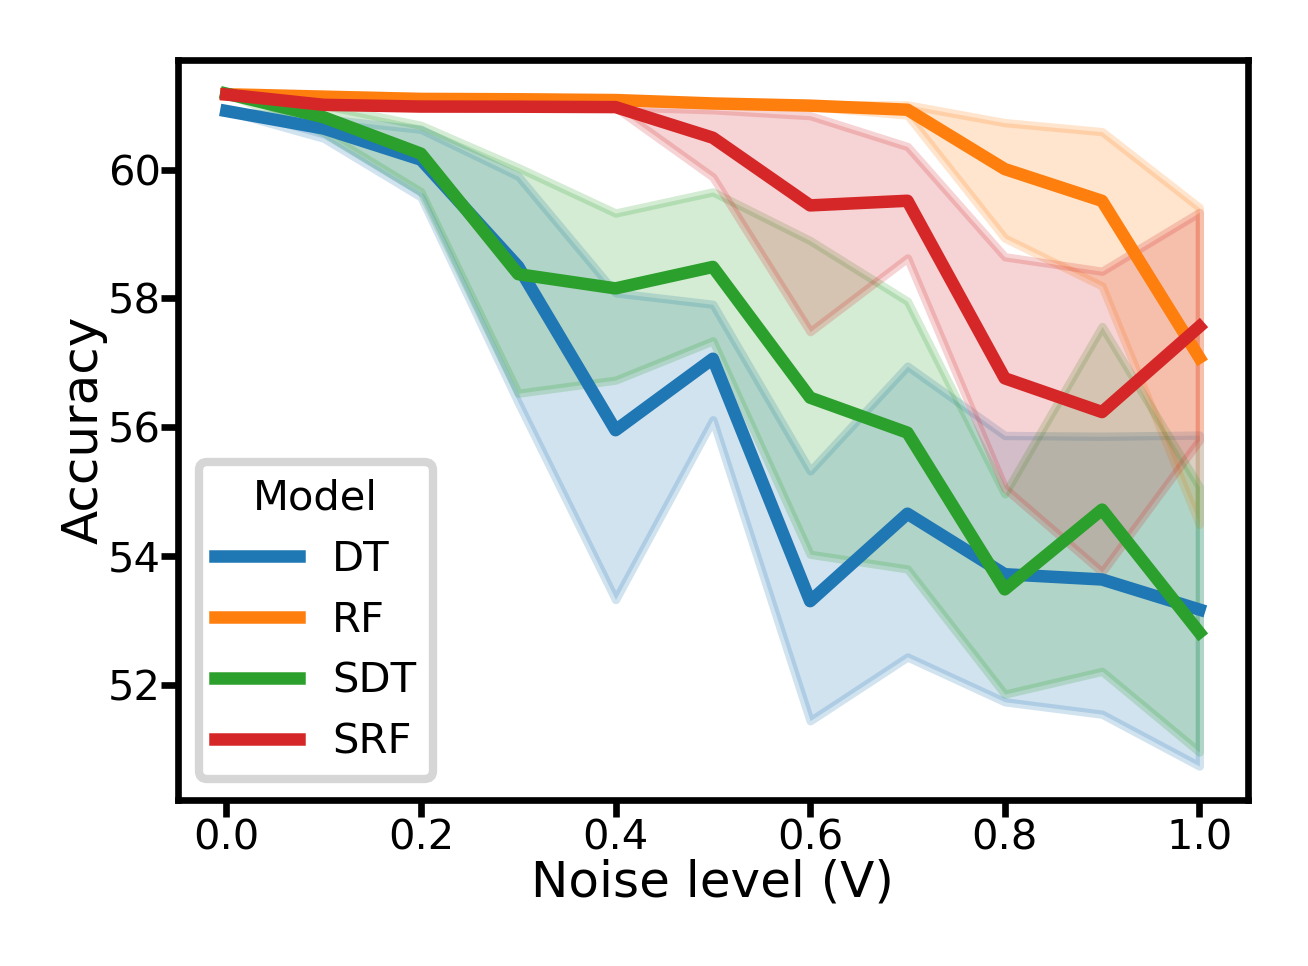

In [131]:
plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=True
plt.style.use('default')
fig, ax = plt.subplots(dpi=600,figsize=(2.28,1.71),layout='tight')
# sns.set_style('whitegrid')
sns.lineplot(data=acc_all,x='Noise level',y='Accuracy',hue='Model')
# if noise_type==0:
    # plt.plot([0.1,0.1],[70,110],'k--')
    # plt.arrow(x=0.1,y=92,dx=-0.07,dy=0,length_includes_head=True,head_width = 0.3,head_length=0.01,fill=True,color='k')
    # plt.text(0.032,92.6,'Exp noise',fontsize=5)
    # plt.xlim(0,.3)
    # plt.ylim(80,102)

# if noise_type==1:
#     plt.plot([0.3,0.3],[70,110],'k--')
#     plt.arrow(x=0.3,y=92,dx=-0.155,dy=0,length_includes_head=True,head_width = 0.3,head_length=0.03,fill=True,color='k')
#     plt.text(0.15,92.6,'Exp noise')
    # plt.xlim(0,.3)
    # plt.ylim(80,102)
    
plt.xlabel('Noise level (V)',fontsize=6,labelpad=0)
plt.ylabel('Accuracy',fontsize=6,labelpad=0)
ax.tick_params(axis='y', which='major', length=2,pad=0,labelsize=5)
ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
plt.legend(['DT','_','RF','_','SDT','_','SRF',],fontsize=5,title='Model',title_fontsize=5)
# plt.savefig('./credit accuracy under uniform noise.svg',transparent=True,dpi=200)



In [ ]:
task_name

In [ ]:
# clf = load('./sdt_model/'+'AEF_'+str(best_depth)+'clf.joblib') 
# tree = SDT(clf,node_depth,node_path_left_right,args)
# save_path = './sdt_model/'+'AEF_'+str(best_depth)+'_sdt_'+str(96.40741448499904)+'.pth'
# tree.load_state_dict(torch.load(save_path))
# load_tree.eval()

In [ ]:
X_test_noise = np.array(X_test).copy()
root_feature = clf.tree_.feature[0]
X_test_noise[:,root_feature] = np.random.random(X_test_noise[:,root_feature].shape)



test_loader_noise = torch.utils.data.DataLoader(
        make_dataset(X= X_test_noise, y=y_test),
        batch_size=50,
        shuffle=False,
    )


# test_loader_noise = torch.utils.data.DataLoader(
#         Mnist_dataset(X_train,
#                         X_test_noise,
#                         Y_train,
#                         Y_test,
#                         train_flag=0),
#         batch_size=100,
#         shuffle=False,
#     )

In [ ]:
plt.hist(X_test_noise)

In [ ]:
X_test

In [ ]:
np.argmax(y_test,1)

In [ ]:

tree.eval()
correct = 0.
load_tree = load_tree.to(device)
for batch_idx, (data, target) in enumerate(test_loader):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)
    
    # output = torch.softmax(tree.forward(data),dim=1)
    output = load_tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

In [ ]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader_noise):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

In [ ]:
torch.argmax(torch.tensor(y_test),1)

In [ ]:

val_preds_baseline = clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

In [ ]:
val_preds_baseline = clf.predict(X_test)
acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

In [ ]:
thres_mean = torch.mean(tree.node_threshold.data)
thres_std = torch.std(tree.node_threshold.data)

In [ ]:
plt.hist(tree.node_threshold.data.cpu().reshape(1,-1),20)

In [ ]:
accuracy

In [ ]:
noise_type = 0 # uniform 1 gaussian 0
acc_all = pd.DataFrame()
for noise_level in np.arange(0,1.01,0.05):
    for i in range(100):
        clf_new = load('./sdt_model/'+'iris_'+str(best_depth)+'_dt_'+str(np.round(accuracy,2))+'.joblib') 
        correct = 0.
        



        load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
        load_tree.load_state_dict(torch.load(save_path))
        load_tree.eval()
        load_tree = load_tree.to(device)
        if noise_type:
            load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.random(tree.node_threshold.data.shape)*noise_level-0.5*noise_level)
        else:
            load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.randn(tree.node_threshold.data.shape[0],tree.node_threshold.data.shape[1])*noise_level)
        new_clf = DecisionTreeClassifier(max_depth=best_depth)
        new_clf.tree_ = clf_new.tree_
        new_clf = deepcopy(clf_new)
        if noise_type:
            new_clf.tree_.threshold[:] = clf.tree_.threshold[:] + np.random.random(clf.tree_.threshold[:].shape)*noise_level-0.5*noise_level
        else:
            new_clf.tree_.threshold[:] = clf.tree_.threshold[:] + np.random.randn(clf.tree_.threshold[:].shape[0])*noise_level

        val_preds_baseline = new_clf.predict(X_test)
        acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
        # print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')
        # acc_dt = pd.DataFrame([acc_baseline_val,'DT'],columns=['Accuracy','Model'])
        # acc_dt = pd.DataFrame()
        acc_dt = pd.DataFrame([acc_baseline_val],columns=['Accuracy'])
        # acc_dt['Accuracy']=acc_baseline_val
        acc_dt['Model']='DT'
        acc_dt['Noise level']=noise_level
        acc_all = pd.concat((acc_all,acc_dt),axis=0,ignore_index=True)

        correct = 0.

        for batch_idx, (data, target) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)

            # output = torch.softmax(tree.forward(data),dim=1)
            output = load_tree.forward(data)

            pred = torch.argmax(output,1)
            correct += pred.eq(torch.argmax(target,1)).sum()
        accuracy_current = 100.0 * float(correct) / len(test_loader.dataset)
        # print(accuracy)
        # acc_sdt = pd.DataFrame([accuracy,'SDT'],columns=['Accuracy','Model'])
        acc_sdt = pd.DataFrame([accuracy_current],columns=['Accuracy'])
        # acc_sdt['Accuracy']=accuracy
        acc_sdt['Model']='SDT'
        acc_sdt['Noise level']=noise_level
        acc_all = pd.concat((acc_all,acc_sdt),axis=0,ignore_index=True)
    # acc_all.append([acc_baseline_val,accuracy])
# print(np.mean(acc_all,0))

In [ ]:
acc_all

In [ ]:
plt.figure(dpi=200)
sns.set_style('white')
sns.lineplot(data=acc_all,x='Noise level',y='Accuracy',hue='Model')
if noise_type==0:

    plt.xlim(0,0.3)
    plt.ylim(80,101)
# if noise_type == 1:
    # plt.xlim(0,1)
    # plt.ylim(90,101)
# plt.savefig(trans)


In [ ]:

new_clf = deepcopy(clf)

In [ ]:
plt.hist(clf.tree_.threshold,20)

In [ ]:
new_clf.tree_.threshold.data.shape

In [ ]:
new_clf.tree_.threshold[:] = clf.tree_.threshold[:] + np.random.random(clf.tree_.threshold[:].shape)*1-0.5

In [ ]:
val_preds_baseline = new_clf.predict(X_test)
acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

In [ ]:
val_preds_baseline = new_clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

In [ ]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

In [ ]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader_noise):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

In [ ]:
plt.hist(products[1,:])

In [ ]:
products[np.arange(10000),np.argsort(products[:,:],1)[:,-1]]

In [ ]:
plt.hist(np.max(products,1))

In [ ]:
_mu = tree._forward(data)

In [ ]:
_mu

In [ ]:
torch.max(_mu,1).

In [ ]:
target[10]

In [ ]:
plt.plot(tree.leaf_nodes[10].detach().numpy())

In [ ]:
plt.plot(tree.leaf_nodes[8].detach().numpy())

In [ ]:
plt.imshow(data[10,:].reshape(7,7))

In [ ]:
X_train_resize.shape

In [ ]:
clf.tree_.feature